In [23]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
# parameters for data load
num_words = 30000
maxlen = 50
test_split = 0.3

In [3]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = num_words, maxlen = maxlen, test_split = test_split)

In [4]:
# pad the sequences with zeros 
# padding parameter is set to 'post' => 0's are appended to end of sequences
X_train = pad_sequences(X_train, padding = 'post')
X_test = pad_sequences(X_test, padding = 'post')

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

y_data = np.concatenate((y_train, y_test))
y_data = to_categorical(y_data)
y_train = y_data[:1395]
y_test = y_data[1395:]

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1395, 49, 1)
(599, 49, 1)
(1395, 46)
(599, 46)


## 1. Deep RNN
- RNNs can be made deep, with multiple layers, like CNNs or MLPs
- Beware that RNNs take long to train compared to CNNs

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras import optimizers

In [7]:
def deep_lstm():
    model = Sequential()
    model.add(LSTM(20, input_shape = (49,1), return_sequences = True))
    model.add(LSTM(20, return_sequences = True))
    model.add(LSTM(20, return_sequences = True))
    model.add(LSTM(20, return_sequences = False))
    model.add(Dense(46))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [8]:
model = deep_lstm()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 49, 20)            1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 49, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 49, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 46)                966       
_________________________________________________________________
activation (Activation)      (None, 46)                0         
Total params: 12,566
Trainable params: 12,566
Non-trainable params: 0
____________________________________________________

In [9]:
history = model.fit(X_train, y_train, verbose=1, batch_size=32, epochs=100, validation_split=0.2)

Train on 1116 samples, validate on 279 samples
Epoch 1/100
1116/1116 [==============================] - 11s 10ms/sample - loss: 3.0964 - accuracy: 0.6738 - val_loss: 2.2260 - val_accuracy: 0.7240
Epoch 2/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.7453 - accuracy: 0.7124 - val_loss: 1.3350 - val_accuracy: 0.7240
Epoch 3/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.2949 - accuracy: 0.7124 - val_loss: 1.1744 - val_accuracy: 0.7240
Epoch 4/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.2243 - accuracy: 0.7124 - val_loss: 1.1418 - val_accuracy: 0.7240
Epoch 5/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.2055 - accuracy: 0.7124 - val_loss: 1.1279 - val_accuracy: 0.7240
Epoch 6/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.1954 - accuracy: 0.7124 - val_loss: 1.1193 - val_accuracy: 0.7240
Epoch 7/100
1116/1116 [==============================] - 3s 3ms/sampl

1116/1116 [==============================] - 3s 3ms/sample - loss: 0.8452 - accuracy: 0.7778 - val_loss: 0.8675 - val_accuracy: 0.7670
Epoch 57/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.7899 - accuracy: 0.7948 - val_loss: 0.7803 - val_accuracy: 0.8065
Epoch 58/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.7700 - accuracy: 0.7930 - val_loss: 0.7745 - val_accuracy: 0.8065
Epoch 59/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.7556 - accuracy: 0.7993 - val_loss: 0.7856 - val_accuracy: 0.8065
Epoch 60/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.7477 - accuracy: 0.7993 - val_loss: 0.7627 - val_accuracy: 0.8208
Epoch 61/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.7596 - accuracy: 0.7957 - val_loss: 0.7586 - val_accuracy: 0.8136
Epoch 62/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.7486 - accuracy: 0.7957 - val_loss: 0.7628 

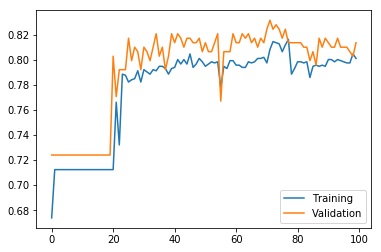

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])

plt.show()

In [13]:
results = model.evaluate(X_test, y_test, verbose=0)
results

[0.8340369721684909, 0.7996661]

In [14]:
model.metrics_names

['loss', 'accuracy']

## 2. Bidirectional RNN
- Bidirectional RNNs consider not only one-way influence of sequence, but also the other way
- Actually, they can be thought as building two separate RNNs, and merging them
<br>
<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/bidirectional-rnn.png" style="width: 400px"/>
</br>

In [15]:
from tensorflow.keras.layers import Bidirectional

In [16]:
def bidirectional_lstm():
    model = Sequential()
    model.add(Bidirectional(LSTM(20, return_sequences = False), input_shape = (49,1)))
    model.add(Dense(46))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [17]:
model = bidirectional_lstm()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 40)                3520      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                1886      
_________________________________________________________________
activation_1 (Activation)    (None, 46)                0         
Total params: 5,406
Trainable params: 5,406
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train, y_train, verbose=1, batch_size=32, epochs=100, validation_split=0.2)

Train on 1116 samples, validate on 279 samples
Epoch 1/100
1116/1116 [==============================] - 5s 4ms/sample - loss: 2.9278 - accuracy: 0.6111 - val_loss: 2.0561 - val_accuracy: 0.7240
Epoch 2/100
1116/1116 [==============================] - 1s 934us/sample - loss: 1.5631 - accuracy: 0.7124 - val_loss: 1.2427 - val_accuracy: 0.7240
Epoch 3/100
1116/1116 [==============================] - 1s 987us/sample - loss: 1.2441 - accuracy: 0.7124 - val_loss: 1.1345 - val_accuracy: 0.7240
Epoch 4/100
1116/1116 [==============================] - 1s 1ms/sample - loss: 1.1863 - accuracy: 0.7124 - val_loss: 1.1042 - val_accuracy: 0.7240
Epoch 5/100
1116/1116 [==============================] - 1s 1ms/sample - loss: 1.1667 - accuracy: 0.7124 - val_loss: 1.0886 - val_accuracy: 0.7240
Epoch 6/100
1116/1116 [==============================] - 1s 1ms/sample - loss: 1.1413 - accuracy: 0.7124 - val_loss: 1.0463 - val_accuracy: 0.7240
Epoch 7/100
1116/1116 [==============================] - 1s 896us/s

1116/1116 [==============================] - 1s 939us/sample - loss: 0.6823 - accuracy: 0.8253 - val_loss: 0.7133 - val_accuracy: 0.8315
Epoch 56/100
1116/1116 [==============================] - 1s 985us/sample - loss: 0.6766 - accuracy: 0.8208 - val_loss: 0.7123 - val_accuracy: 0.8315
Epoch 57/100
1116/1116 [==============================] - 1s 1ms/sample - loss: 0.6729 - accuracy: 0.8235 - val_loss: 0.7010 - val_accuracy: 0.8423
Epoch 58/100
1116/1116 [==============================] - 1s 1ms/sample - loss: 0.6732 - accuracy: 0.8253 - val_loss: 0.7107 - val_accuracy: 0.8530
Epoch 59/100
1116/1116 [==============================] - 1s 857us/sample - loss: 0.6723 - accuracy: 0.8244 - val_loss: 0.7166 - val_accuracy: 0.8315
Epoch 60/100
1116/1116 [==============================] - 1s 857us/sample - loss: 0.6638 - accuracy: 0.8244 - val_loss: 0.7236 - val_accuracy: 0.8387
Epoch 61/100
1116/1116 [==============================] - 1s 816us/sample - loss: 0.6656 - accuracy: 0.8297 - val_los

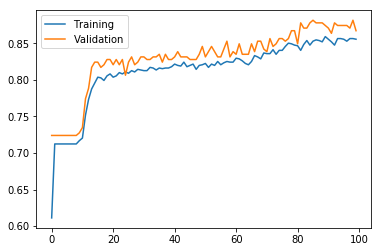

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])

plt.show()

In [20]:
results = model.evaluate(X_test, y_test, verbose=0)
results

[0.7975201439578864, 0.84307176]

In [21]:
model.metrics_names

['loss', 'accuracy']

## 3. Deep Bidirectional RNN
- Bidirectional RNNs can be stacked

<img src="http://www.wildml.com/wp-content/uploads/2015/09/Screen-Shot-2015-09-16-at-2.21.51-PM-272x300.png" style="width: 300px"/>

In [24]:
def deep_bidirectional_lstm():
    model = Sequential()
    model.add(Bidirectional(LSTM(10, return_sequences = True), input_shape = (49,1)))
    model.add(Bidirectional(LSTM(10, return_sequences = True)))
    model.add(Bidirectional(LSTM(10, return_sequences = True)))
    model.add(Bidirectional(LSTM(10, return_sequences = False)))
    model.add(Dense(46))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [25]:
tf.keras.backend.clear_session()

In [26]:
model = deep_lstm()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 49, 20)            1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 49, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 49, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 46)                966       
_________________________________________________________________
activation (Activation)      (None, 46)                0         
Total params: 12,566
Trainable params: 12,566
Non-trainable params: 0
____________________________________________________

In [27]:
history = model.fit(X_train, y_train, verbose=1, batch_size=32, epochs=100, validation_split=0.2)

Train on 1116 samples, validate on 279 samples
Epoch 1/100
1116/1116 [==============================] - 11s 10ms/sample - loss: 3.1474 - accuracy: 0.6120 - val_loss: 2.2615 - val_accuracy: 0.7240
Epoch 2/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.7604 - accuracy: 0.7124 - val_loss: 1.3313 - val_accuracy: 0.7240
Epoch 3/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.3060 - accuracy: 0.7124 - val_loss: 1.1750 - val_accuracy: 0.7240
Epoch 4/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.2310 - accuracy: 0.7124 - val_loss: 1.1377 - val_accuracy: 0.7240
Epoch 5/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.2084 - accuracy: 0.7124 - val_loss: 1.1237 - val_accuracy: 0.7240
Epoch 6/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 1.1974 - accuracy: 0.7124 - val_loss: 1.1165 - val_accuracy: 0.7240
Epoch 7/100
1116/1116 [==============================] - 3s 3ms/sampl

1116/1116 [==============================] - 3s 3ms/sample - loss: 0.8130 - accuracy: 0.7948 - val_loss: 0.7916 - val_accuracy: 0.8065
Epoch 57/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.8161 - accuracy: 0.7948 - val_loss: 0.8039 - val_accuracy: 0.8100
Epoch 58/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.8209 - accuracy: 0.7912 - val_loss: 0.7998 - val_accuracy: 0.8065
Epoch 59/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.8115 - accuracy: 0.7957 - val_loss: 0.7981 - val_accuracy: 0.8100
Epoch 60/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.8157 - accuracy: 0.7930 - val_loss: 0.7957 - val_accuracy: 0.8065
Epoch 61/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.8264 - accuracy: 0.7885 - val_loss: 0.7915 - val_accuracy: 0.8100
Epoch 62/100
1116/1116 [==============================] - 3s 3ms/sample - loss: 0.8154 - accuracy: 0.7903 - val_loss: 0.7882 

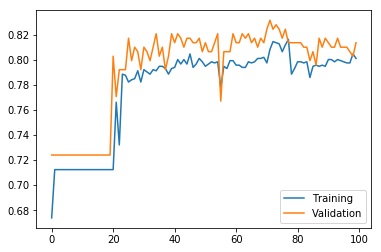

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])

plt.show()

In [13]:
results = model.evaluate(X_test, y_test, verbose=0)
results

[0.8340369721684909, 0.7996661]

In [14]:
model.metrics_names

['loss', 'accuracy']